In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants, UKBB_index_tools

from utilities import *

In [2]:
DEV_MODE = True

UK_BIOBANK_DATA_PATH = constants.UK_BIOBANK_DEV_DATA_CSV if DEV_MODE else constants.UK_BIOBANK_DATA_CSV


# ukbb_data_file = "small_ukbiobank.csv" if DEV_MODE else "ukbiobank.csv"
# ukbb_data_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, ukbb_data_file)

# ukbb_index_html_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank.html")
# ukbb_index_csv_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank_index.csv")

In [3]:
# Plot helpers
# def titleize(label: str) -> str:
#     """"""
#     return label.replace("_", " ").title()


# def add_plt_labels(ax, x: str, y: str, title: Optional[str] = None, **kwargs) -> None:
#     ax.set_xlabel(titleize(x))
#     ax.set_ylabel(titleize(y))
#     if title:
#         ax.set_title(titleize(title))

# Data Index

In [4]:
ukbb_index = UKBB_index_tools.load_index()

In [11]:
# def split_data_coding(data_coding: str):
#     if len(data_coding) == 0:
#         return [None, None, None, None]

#     _, data_coding, _, n_members, data_type, _, _, _, pretype, type_ = data_coding.lower().split()
#     return [int(data_coding), int(n_members), data_type, pretype + "_" + type_.rstrip(".")]


# if os.path.exists(constants.UK_BIOBANK_INDEX_CSV_PATH):
#     ukbb_index = pd.read_csv(constants.UK_BIOBANK_INDEX_CSV_PATH)
# else:
#     ukbb_html = bsoup(open(constants.UK_BIOBANK_INDEX_HTML_PATH,'r').read())
#     ukbb_index_html = ukbb_html.find_all("table")[1]
#     ukbb_index = pd.read_html(str(ukbb_index_html))[0]
#     ukbb_index.columns = [col.lower() for col in ukbb_index.columns]
#     ukbb_index.to_csv(constants.UK_BIOBANK_INDEX_CSV_PATH, index=False)

# ukbb_index["data_coding"] = ukbb_index["description"].apply(lambda desc: desc.split("Uses")[1] if "Uses" in desc else "")
# ukbb_index["description"] = ukbb_index["description"].apply(lambda desc: desc.split("Uses")[0])



# data_info = pd.DataFrame(data=np.array(ukbb_index["data_coding"].apply(split_data_coding).to_list()),
#                          columns=["data_code", "data_n_members", "data_type", "data_structure"])
# ukbb_index = pd.concat([ukbb_index, data_info], axis=1).drop(["data_coding"], axis=1)

In [16]:
def load_partial_udi_lookup_map() -> dict:
    """ Loads the UDI lookup tables"""
    core_udi_lookup = pd.read_csv(constants.UDI_LOOKUP_CORE_CSV)
    outlier_udi_lookup = pd.read_csv(constants.UDI_LOOKUP_OUTLIERS_CSV)
    
    partial_udi_lookup = pd.concat([core_udi_lookup, outlier_udi_lookup])

    partial_labeled_udis = partial_udi_lookup.loc[partial_udi_lookup["name"] != "_"]
    partial_udi_to_name_map = dict(zip(partial_labeled_udis["udi"], partial_labeled_udis["name"]))
    return partial_udi_to_name_map


def create_full_udi_lookup_maps() -> Tuple[dict, dict]:

{'eid': 'eid',
 '23-0.0': 'spirometry_method',
 '31-0.0': 'sex',
 '34-0.0': 'birth_year',
 '35-0.0': 'blood_sample_attempted',
 '36-0.0': 'bp_device',
 '37-0.0': 'bp_manual_device_ID',
 '42-0.0': 'spirometry_device_ID',
 '52-0.0': 'birth_month',
 '53-0.0': 'assessment_date',
 '54-0.0': 'assessment_center',
 '68-0.0': 'n_blood_samples',
 '74-0.0': 'fasting_time',
 '84-0.0': 'cancer_first_year_age',
 '87-0.0': 'illness_first_year_age',
 '92-0.0': 'operation_first_year_age',
 '93-0.0': 'systolic_bp_manual',
 '94-0.0': 'systolic_bp_manual',
 '95-0.0': 'pulse_rate_manual',
 '96-0.0': 'bp_start_time',
 '102-0.0': 'pulse_rate_auto',
 '120-0.0': 'birth_weight',
 '129-0.0': 'birth_place_north',
 '130-0.0': 'birth_place_east',
 '132-0.0': 'job',
 '134-0.0': 'n_cancers',
 '135-0.0': 'n_non_cancer_illnesses',
 '136-0.0': 'n_operations',
 '137-0.0': 'n_treatments',
 '189-0.0': 'deprivation_index',
 '190-0.0': 'lost_to_follow_reason',
 '191-0.0': 'lost_to_follow_up_date',
 '670-0.0': 'living_accomod

In [6]:



outlier_udi_lookup = pd.read_csv("resources/outlier_udi_lookup.csv", sep=",")
core_udi_lookup = pd.read_csv("resources/core_udi_lookup.csv", sep=",")
partial_udi_lookup = pd.concat([core_udi_lookup, outlier_udi_lookup])

partial_labeled_udis = partial_udi_lookup.loc[partial_udi_lookup["name"] != "_"]
partial_udi_to_name_map = dict(zip(partial_labeled_udis["udi"], partial_labeled_udis["name"]))

names = []
for udi in ukbb_index["udi"]:
    if "-" not in udi or udi.endswith("-0.0"):
        names.append(partial_udi_to_name_map.get(udi, None))
    else:
        udi_stem, udi_modifier = udi.split("-")
        new_name = None
        
        if udi_stem + "-0.0" in partial_udi_to_name_map:
            names.append(f"{partial_udi_to_name_map[udi_stem + '-0.0']}_{udi_modifier}")
        elif udi_stem + "-0.1" in partial_udi_to_name_map:
            names.append(f"{partial_udi_to_name_map[udi_stem + '-0.1']}_{udi_modifier}")
        else:
            names.append(None)

ukbb_index["name"] = names
udi_to_name_map = dict(zip(ukbb_index["udi"], ukbb_index["name"]))
name_to_udi_map = dict(zip(ukbb_index["name"], ukbb_index["udi"]))

# ukbb_index = ukbb_index[['column', 'udi', 'count', "type", 'counts', 'frequency', "name",
#                          'description', 'data_code', 'data_n_members', 'data_type', 'data_structure']]

In [ ]:
def get_udi(name):
    if isinstance(name, str):
        return name_to_udi_map.get(name, name)

    return [get_udi(name_i) for name_i in name]


def get_name_from_udi(udi):
    if isinstance(udi, str):
        return udi_to_name_map.get(udi, udi)

    return [get_name_from_udi(udi_i) for udi_i in udi]


def udi_wrapper(function, *args, **kwargs) -> Any:
    """"""
    args = {get_udi(arg) for arg in args}
    kwargs = {key: get_udi(value) if isinstance(value, str) else value for key, value in kwargs.items()}
    return function(*args, **kwargs)


def relevant_feature_search(ukbb_index: pd.DataFrame, term: str) -> pd.DataFrame:
    """"""
    modified_names = ukbb_index["name"].apply(lambda s: s.replace("_", " ") + " " if s else "")
    found_indices = [i for (i, description) in enumerate(modified_names + ukbb_index["description"])
                     if fuzz.partial_ratio(description.lower(), term.lower()) > 95]
    return ukbb_index.iloc[found_indices]

In [ ]:
ukbb_index.head()

In [ ]:
relevant_feature_search(ukbb_index, "HTN")

# Load BioBank Data

In [8]:
ukbb_data = pd.read_csv(ukbb_data_path, low_memory=False)
ukbb_data.head()

,eid,23-0.0,23-1.0,23-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,41240-0.0,41241-0.0,41247-0.0,41247-0.1,41247-0.2,41247-0.3,41247-0.4,41247-0.5,41247-0.6,41252-0.0
0,1000015,0.0,NaN,NaN,1,1963,1.0,NaN,NaN,157.0,...,2.0,3.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,5.0
1,1000027,0.0,NaN,NaN,0,1956,1.0,NaN,NaN,3157.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1000039,NaN,NaN,NaN,0,1948,1.0,NaN,NaN,1048.0,...,13.0,15.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,19.0
3,1000040,0.0,NaN,NaN,1,1947,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,1000053,0.0,NaN,0.0,0,1962,1.0,NaN,1.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
1,1,23-0.0,456606,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method,9056,0.905691
2,2,23-1.0,18135,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method_1.0,363,0.036304
3,3,23-2.0,26790,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method_2.0,528,0.052805
4,4,31-0.0,502543,Categorical (single),Sex,9,2,integer-valued,simple_list,sex,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted,9978,0.997900
7,7,35-1.0,20337,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted_1.0,412,0.041204
8,8,35-2.0,29389,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted_2.0,575,0.057506
9,9,36-0.0,497907,Text,Blood pressure device ID,None,None,None,None,bp_device,9907,0.990799


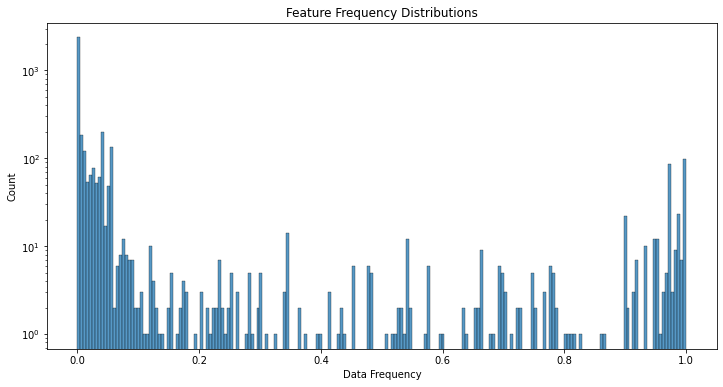

,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
4,4,31-0.0,502543,Categorical (single),Sex,9,2,integer-valued,simple_list,sex,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted,9978,0.997900
9,9,36-0.0,497907,Text,Blood pressure device ID,None,None,None,None,bp_device,9907,0.990799
...,...,...,...,...,...,...,...,...,...,...,...,...
2718,2718,20117-0.0,501646,Categorical (single),Alcohol drinker status,90,4,integer-valued,simple_list,alcohol_use_status,9969,0.997000
2734,2734,20160-0.0,499657,Categorical (single),Ever smoked,7,2,integer-valued,simple_list,tobacco_smoking_ever,9927,0.992799
2743,2743,21000-0.0,501645,Categorical (single),Ethnic background,1001,22,integer-valued,hierarchical_tree,ethnic_background,9969,0.997000
2746,2746,21003-0.0,502543,Integer,Age when attended assessment centre,None,None,None,None,assessment_age,9999,1.000000


In [9]:
ukbb_index["counts"] = np.array(ukbb_data.count().tolist())
ukbb_index["frequency"] = ukbb_index["counts"] / len(ukbb_data)
display(ukbb_index.head(10))

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(ukbb_index["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig("cover_plots/feature_frequency_distribution.png")

display(ukbb_index.query("frequency > .99"))

# actual EDA

In [12]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

NameError: name 'udi_wrapper' is not defined

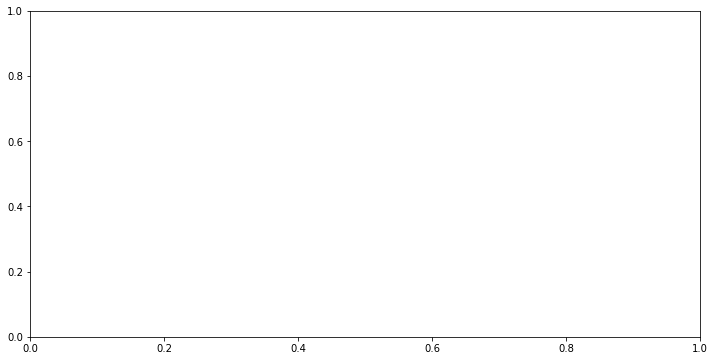

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"
udi_wrapper(sns.kdeplot, data=ukbb_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
ax = udi_wrapper(sns.kdeplot, data=ukbb_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

In [ ]:

x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")